Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
291
127
['BACKGROUND_Google', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera']
There are 15 total categories.
There are 291 training images.
There are 127 test images.


100%|██████████| 127/127 [01:31<00:00,  1.38it/s]


Accuracy: 0.3543307086614173


                   precision    recall  f1-score   support

BACKGROUND_Google       0.36      0.93      0.52        46
        accordion       1.00      0.00      0.00         4
        airplanes       0.00      0.00      0.00        13
           anchor       1.00      0.00      0.00         4
              ant       0.00      0.00      0.00         4
           barrel       1.00      0.00      0.00         4
             bass       1.00      0.00      0.00         4
           beaver       1.00      0.00      0.00         4
        binocular       0.00      0.00      0.00         2
           bonsai       1.00      0.09      0.17        11
            brain       1.00      0.00      0.00         8
     brontosaurus       0.50      0.33      0.40         3
           buddha       1.00      0.00      0.00         8
        butterfly       0.00      0.00      0.00         8
           camera       1.00      0.00      0.00         4

         accuracy      

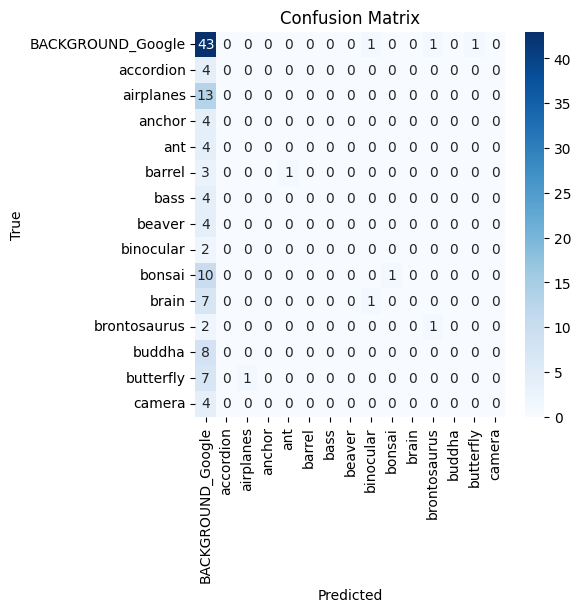

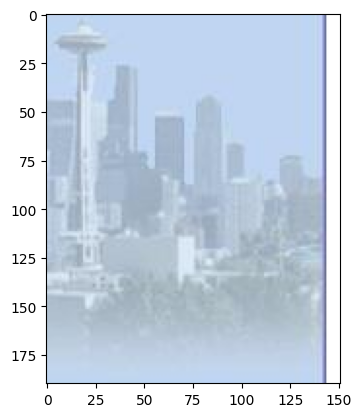

Class label of test sample is: BACKGROUND_Google


In [12]:
from sklearn.datasets import load_files
from keras.utils import to_categorical
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
from PIL import ImageFile
from sklearn import preprocessing
from skimage.color import rgb2lab, rgb2gray
from skimage.feature import SIFT
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from google.colab import drive
import cv2
import seaborn as sns
import pandas as pd

drive.mount('/content/drive')

# Define function to load train and test datasets
def load_dataset(path):
    data = load_files(path)
    condition_files = np.array(data['filenames'])
    print(len(condition_files))
    condition_targets = np.array(data['target'])
    return condition_files, condition_targets

# Load train and test datasets
path_org = '/content/drive/MyDrive/PatternRecognition/HW5/'
train_files, y_train = load_dataset(path_org + 'train')
test_files, y_test = load_dataset(path_org + 'test')

# Extract condition names from file paths
condition_names = [os.path.basename(os.path.dirname(item)) for item in sorted(glob(path_org + 'train/*/'))]
print(condition_names)

# Print statistics about the dataset
print('There are %d total categories.' % len(condition_names))
print('There are %d training images.' % len(train_files))
print('There are %d test images.' % len(test_files))

def path_to_tensor(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_lab = rgb2lab(img)
    img_gray = rgb2gray(img_lab)
    return img_gray

def extract_sift_features(img_path):
    img_gray = path_to_tensor(img_path)
    sift = SIFT()
    sift.detect_and_extract(img_gray)
    descriptors = sift.descriptors
    if descriptors is None:
        return np.zeros((1, 128))
    return descriptors

def extract_features(img_paths):
    all_features = []
    for img_path in tqdm(img_paths):
        features = extract_sift_features(img_path)
        all_features.append(features.flatten())
    return all_features

# Read images and extract features
ImageFile.LOAD_TRUNCATED_IMAGES = True
x_train_features = extract_features(train_files)
x_test_features = extract_features(test_files)

# Padding feature vectors to ensure they have the same length
max_length = max(max(len(f) for f in x_train_features), max(len(f) for f in x_test_features))
x_train_features_padded = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in x_train_features])
x_test_features_padded = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in x_test_features])
pca = PCA(n_components=150)
x_train_features_selected = pca.fit_transform(x_train_features_padded)
x_test_features_selected = pca.transform(x_test_features_padded)

# Step 3: Train with SVM
svm_model = SVC(kernel='linear')
svm_model.fit(x_train_features_selected, y_train)

# Make predictions
y_pred = svm_model.predict(x_test_features_selected)

# Compute accuracy
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('\n')

# Classification report with zero_division parameter
print(classification_report(y_test, y_pred, target_names=condition_names, zero_division=1))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")


# Plotting confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=condition_names, yticklabels=condition_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Sample test prediction
sample_test = x_test_features_selected[3]
plt.imshow(cv2.cvtColor(cv2.imread(test_files[3]), cv2.COLOR_BGR2RGB))
plt.show()

sample_test = np.reshape(sample_test, (1, sample_test.shape[0]))
y_pred_sample_test = svm_model.predict(sample_test)

print('Class label of test sample is:', condition_names[y_pred_sample_test[0]])